In [47]:
# This box deals with importing and defines a few functions.  Do not change.
from __future__ import print_function
import sys
sys.path.append('/opt/Mantid/bin')
sys.path.append('/SNS/users/ntv/integrate/jupyter_demo')
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mantid.simpleapi import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import DemoTools
import ICCFitTools as ICCFT
import pickle

def showModels(x):
    plt.figure(num=1,figsize=(10,10));
    plt.clf()
    vMin = 0
    vMax = 0.8*n_events.max()
    plt.subplot(1,3,1)
    plt.imshow(n_events[:,:,x],vmin=vMin,vmax=vMax)
    plt.title('Data')
    plt.subplot(1,3,2)
    plt.imshow(Y3D1[:,:,x],vmin=vMin,vmax=vMax)
    plt.title('Model (calc bg)')
    plt.subplot(1,3,3)
    plt.imshow(Y3D2[:,:,x],vmin=vMin,vmax=vMax)
    plt.title('Model (est. bg)')


In [71]:
# These are parameters for fitting.

qLow = -5  # Lowest value of q for ConvertToMD 
qHigh = 5; # Highest value of q for ConvertToMD
Q3DFrame='Q_lab' # Either 'Q_lab' or 'Q_sample'; Q_lab recommended if using a strong peaks
                 # profile library from a different sample
eventFileName = '/SNS/MANDI/IPTS-8776/0/5921/NeXus/MANDI_5921_event.nxs' #Full path to the event nexus file
peaksFile = '/SNS/MANDI/shared/ProfileFitting/demo_5921.integrate' #Full path to the ISAW peaks file
UBFile = '/SNS/MANDI/shared/ProfileFitting/demo_5921.mat' #Full path to the ISAW UB file
strongPeakParamsFile = '/SNS/MANDI/shared/ProfileFitting/strongPeakParams_beta_lac_mut_mbvg.pkl' #Full path to pkl file
moderatorCoefficientsFile = '/SNS/MANDI/shared/ProfileFitting/franz_coefficients_2017.dat' #Full path to pkl file
PredPplCoefficients=np.array([3.56405187,  8.34071842,  0.14134522]) #Coefficients for background calculation
DQPixel = 0.003 # The side length of each voxel in the non-MD histogram used for fitting (1/Angstrom)
IntensityCutoff = 200 # Minimum number of counts to not force a profile
EdgeCutoff = 3 # Pixels within EdgeCutoff from a detector edge will be have a profile forced. Currently for Anger cameras only.
FracHKL = 0.5 # Fraction of HKL to consider for profile fitting.
FracStop = 0.05 # Fraction of max counts to include in peak selection.
MinpplFrac = 0.4 # Min fraction of predicted background level to check
MaxpplFrac = 1.5 # Max fraction of predicted background level to check
MindtBinWidth = 15 # Smallest spacing (in microseconds) between data points for TOF profile fitting.
NTheta = 50 # Number of bins for bivarite Gaussian along the scattering angle.
NPhi = 50 # Number of bins for bivariate Gaussian along the azimuthal angle.
DQMax = 0.15 # Largest total side length (in Angstrom) to consider for profile fitting.
DtSpread = 0.015 # The fraction of the peak TOF to consider for TOF profile fitting.

In [72]:
# Do not edit this cell - only need to run once to load everything
event_ws = Load(Filename=eventFileName, OutputWorkspace='event_ws')
MDdata = ConvertToMD(InputWorkspace='event_ws',  QDimensions='Q3D', dEAnalysisMode='Elastic',
                         Q3DFrames=Q3DFrame, QConversionScales='Q in A^-1',
                         MinValues='%f, %f, %f' % (qLow, qLow, qLow), Maxvalues='%f, %f, %f' % (qHigh, qHigh, qHigh), MaxRecursionDepth=10,
                         LorentzCorrection=False)
peaks_ws = LoadIsawPeaks(Filename=peaksFile, OutputWorkspace='peaks_ws')
LoadIsawUB(InputWorkspace=peaks_ws, Filename=UBFile)
UBMatrix = peaks_ws.sample().getOrientedLattice().getUB()
dQ = np.abs(ICCFT.getDQFracHKL(UBMatrix, frac=0.5))
dQ[dQ>0.15]=0.15
strongPeakParams = pickle.load(open(strongPeakParamsFile, 'rb'),encoding='latin1')
padeCoefficients = ICCFT.getModeratorCoefficients(moderatorCoefficientsFile)
np.warnings.filterwarnings('ignore') # There can be a lot of warnings for bad solutions.

Peak 30: Old: 281; New: 281; Ell: 371


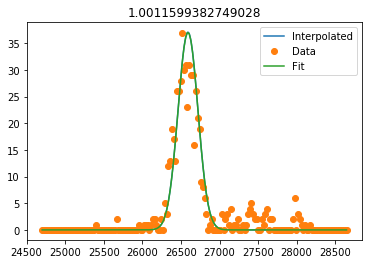

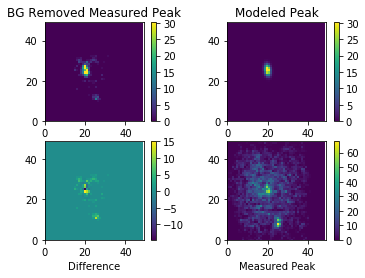

interactive(children=(IntSlider(value=19, continuous_update=False, description='z Slice:', max=42), Output()),…

In [73]:
peakToFit = 30 # Which peak from PeaksFile to fit.  User should make sure the peak is in the loaded run.
plotSeparateResults = True # True to plot TOF/BVG separately in addition to 3D slices
slider, n_events, Y3D1, Y3D2 = DemoTools.showPeakFit(peakToFit, peaks_ws, MDdata, UBMatrix, dQ, 
                                           padeCoefficients,PredPplCoefficients,mindtBinWidth=MindtBinWidth,
                                           dQPixel=DQPixel,fracHKL=FracHKL,dtS=DtSpread,pplmin_frac=MinpplFrac,
                                           pplmax_frac=MaxpplFrac, nTheta=NTheta, nPhi=NPhi,intensityCutoff=IntensityCutoff,
                                           edgeCutoff=EdgeCutoff,fracStop=FracStop,plotResults=plotSeparateResults,
                                            strongPeakParams=strongPeakParams)
interact(showModels, x=slider);

In [37]:
print(np.mean(np.diff(mtd['fit_Workspace'].readX(0))), n_events.max(),Y3D2.max())

9.00446419777 18.0 7.83062735504


In [66]:
q0 = np.array([-0.933221,0.910433,0.548097])
qBounds = np.array([q0,q0]).T + dQ*np.array([-1,1]).T
print(qBounds)

[[-1.00326925 -0.86317275]
 [ 0.85302825  0.96783775]
 [ 0.48324316  0.61295084]]


In [45]:
# These are parameters for fitting - TOPAZ Si
qLow = -25  # Lowest value of q for ConvertToMD 
qHigh = 25; # Highest value of q for ConvertToMD
Q3DFrame='Q_lab' # Either 'Q_lab' or 'Q_sample'; Q_lab recommended if using a strong peaks
                 # profile library from a different sample
eventFileName = '/SNS/TOPAZ/shared/PeakIntegration/data/TOPAZ_15647_event.nxs' #Full path to the event nexus file
peaksFile = '/SNS/TOPAZ/shared/PeakIntegration/DataSet/Si2mm_2016A_15647_15669/Si2mm_Cubic_F.integrate' #Full path to the ISAW peaks file
UBFile = '/SNS/TOPAZ/shared/PeakIntegration/DataSet/Si2mm_2016A_15647_15669/Si2mm_Cubic_F.mat' #Full path to the ISAW UB file
strongPeakParamsFile = '/SNS/users/ntv/integrate/strongPeakParams_beta_lac_mut_mbvg.pkl' #Full path to pkl file
moderatorCoefficientsFile = '/SNS/users/ntv/integrate/franz_coefficients_2010.dat' #Full path to pkl file
PredPplCoefficients=np.array([3.56405187,  8.34071842,  0.14134522]) #Coefficients for background calculation
DQPixel = 0.02 # The side length of each voxel in the non-MD histogram used for fitting (1/Angstrom)
IntensityCutoff = 100 # Minimum number of counts to not force a profile
EdgeCutoff = 10 # Pixels within EdgeCutoff from a detector edge will be have a profile forced. Currently for Anger cameras only.
FracHKL = 0.4 # Fraction of HKL to consider for profile fitting.
FracStop = 0.05 # Fraction of max counts to include in peak selection.
MinpplFrac = 0.0 # Min fraction of predicted background level to check
MaxpplFrac = 1.5 # Max fraction of predicted background level to check
MindtBinWidth = 1 # Smallest spacing (in microseconds) between data points for TOF profile fitting.
NTheta = 50 # Number of bins for bivarite Gaussian along the scattering angle.
NPhi = 50 # Number of bins for bivariate Gaussian along the azimuthal angle.
DQMax = 0.15 # Largest total side length (in Angstrom) to consider for profile fitting.
DtSpread = 0.015 # The fraction of the peak TOF to consider for TOF profile fitting.
padeCoefficients = ICCFT.getModeratorCoefficients(moderatorCoefficientsFile)
dQ = np.abs(ICCFT.getDQFracHKL(UBMatrix, frac=0.5))
dQ[dQ>0.3]=0.3